In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

sns.set(style="whitegrid")

In [2]:
# Load the dataset
df = pd.read_csv("marksheet.csv")
df.head()

# Calculate total marks
df["Total_Marks"] = df["Maths"] + df["Science"] + df["English"] + df["History"]

# Calculate percentage (needed for grading)
df["Percentage"] = (df["Total_Marks"] / 400) * 100

df[["Name", "Total_Marks", "Percentage"]].head()

,Name,Total_Marks,Percentage
0,Bronnie,213,53.25
1,Lemmie,127,31.75
2,Danya,211,52.75
3,Denna,183,45.75
4,Jocelin,73,18.25


In [3]:
# Generate Exam_Type feature - exactly 125 Regular and 125 Supplementary
np.random.seed(42)

# Create array with exactly 125 of each type
n_students = len(df)
n_regular = n_students // 2  # 125 students
n_supplementary = n_students - n_regular  # 125 students

exam_types = ['Regular'] * n_regular + ['Supplementary'] * n_supplementary

# Shuffle to randomize the assignment
np.random.shuffle(exam_types)

df["Exam_Type"] = exam_types

# Check distribution
print("Exam Type Distribution:")
print(df["Exam_Type"].value_counts())

Exam Type Distribution:
Exam_Type
Supplementary    125
Regular          125
Name: count, dtype: int64



Final Grade Distribution:
Final_Grade
Pass    72
F       67
Fail    53
B+      20
P       14
B       12
C        7
A        4
A+       1
Name: count, dtype: int64


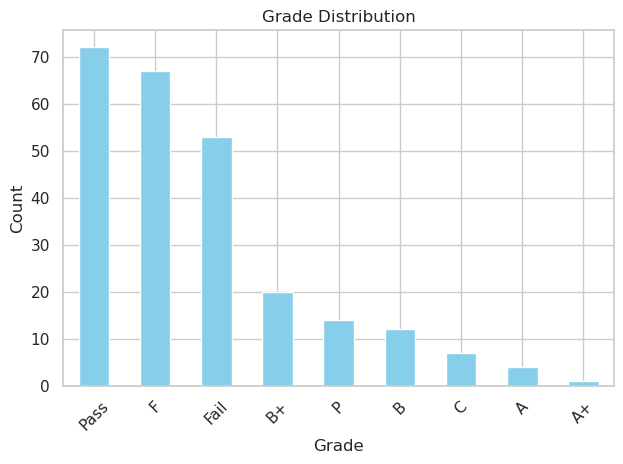

In [4]:

# Assign grades based on Exam_Type
# For Regular: use grading scale
# For Supplementary: only Pass/Fail

def assign_grade(row):
    if row["Exam_Type"] == "Regular":
        # Regular exam grading
        p = row["Percentage"]
        if p >= 91:
            return "O"
        elif p >= 85:
            return "A+"
        elif p >= 75:
            return "A"
        elif p >= 65:
            return "B+"
        elif p >= 60:
            return "B"
        elif p >= 55:
            return "C"
        elif p >= 50:
            return "P"
        else:
            return "F"
    else:
        # Supplementary exam - only Pass/Fail
        if row["Total_Marks"] >= 200:  # 50% of 400
            return "Pass"
        else:
            return "Fail"

df["Final_Grade"] = df.apply(assign_grade, axis=1)

print("\nFinal Grade Distribution:")
print(df["Final_Grade"].value_counts())

# Visualize grade distribution
df["Final_Grade"].value_counts().plot(kind='bar', color='skyblue')
plt.title('Grade Distribution')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Prepare features for machine learning and training 2 models:
# One with Exam_type as a feature and one without it

# Features without Exam_Type
X_without = df[["Maths", "Science", "English", "History"]]

# Features with Exam_Type (need to convert to numeric since we need numeric values to classify)
df["Exam_Type_Numeric"] = (df["Exam_Type"] == "Regular").astype(int)  # Regular=1, Supplementary=0
X_with = df[["Maths", "Science", "English", "History", "Exam_Type_Numeric"]]

# Target variable
y = df["Final_Grade"]

print("Feature sets prepared:")
print(f"Without Exam_Type: {X_without.shape}")
print(f"With Exam_Type: {X_with.shape}")

# Train Model 1: WITHOUT Exam_Type feature
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_without, y, test_size=0.2, random_state=42
)

model1 = DecisionTreeClassifier(random_state=42)
model1.fit(X_train_1, y_train_1)
y_pred_1 = model1.predict(X_test_1)

acc1 = accuracy_score(y_test_1, y_pred_1)
f1_1 = f1_score(y_test_1, y_pred_1, average='weighted')

print("Model WITHOUT Exam_Type")
print(f"Accuracy: {acc1}")
print(f"F1 Score: {f1_1}")

# Train Model 2: WITH Exam_Type feature
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_with, y, test_size=0.2, random_state=42
)

model2 = DecisionTreeClassifier(random_state=42)
model2.fit(X_train_2, y_train_2)
y_pred_2 = model2.predict(X_test_2)

acc2 = accuracy_score(y_test_2, y_pred_2)
f1_2 = f1_score(y_test_2, y_pred_2, average='weighted')

print("Model WITH Exam_Type")
print(f"Accuracy: {acc2}")
print(f"F1 Score: {f1_2}")

Feature sets prepared:
Without Exam_Type: (250, 4)
With Exam_Type: (250, 5)
Model WITHOUT Exam_Type
Accuracy: 0.24
F1 Score: 0.22086580086580085
Model WITH Exam_Type
Accuracy: 0.74
F1 Score: 0.7156175334998863


Comparison
               Model  Accuracy  F1 Score
0  Without Exam_Type      0.24  0.220866
1     With Exam_Type      0.74  0.715618

Accuracy improvement: 208.33%


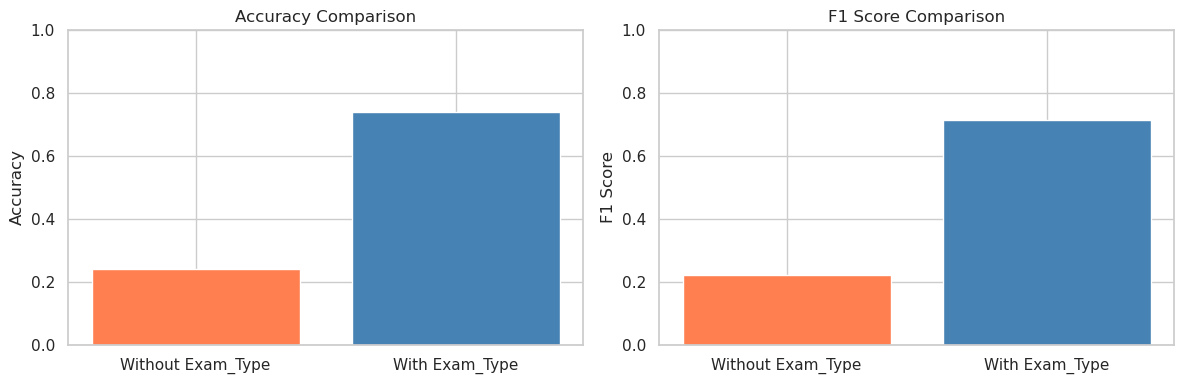

In [6]:
# Comparing the two models
print("Comparison")
comparison = pd.DataFrame({
    "Model": ["Without Exam_Type", "With Exam_Type"],
    "Accuracy": [acc1, acc2],
    "F1 Score": [f1_1, f1_2]
})
print(comparison)

# Calculate improvement
improvement = ((acc2 - acc1) / acc1) * 100
print(f"\nAccuracy improvement: {improvement:.2f}%")

# Bar chart comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

models = ['Without Exam_Type', 'With Exam_Type']
accuracies = [acc1, acc2]
f1_scores = [f1_1, f1_2]

ax[0].bar(models, accuracies, color=['coral', 'steelblue'])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylim([0, 1])

ax[1].bar(models, f1_scores, color=['coral', 'steelblue'])
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score Comparison')
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [7]:
def predict_student_performance(
    maths, science, english, history, exam_type,
    use_exam_type_model=True
):
    if exam_type not in ["Regular", "Supplementary"]:
        raise ValueError("exam_type must be 'Regular' or 'Supplementary'")

    # Prepare feature vector
    if use_exam_type_model:
        exam_type_numeric = 1 if exam_type == "Regular" else 0
        X_input = pd.DataFrame(
            [[maths, science, english, history, exam_type_numeric]],
            columns=["Maths", "Science", "English", "History", "Exam_Type_Numeric"]
        )
        prediction = model2.predict(X_input)[0]
    else:
        X_input = pd.DataFrame(
            [[maths, science, english, history]],
            columns=["Maths", "Science", "English", "History"]
        )
        prediction = model1.predict(X_input)[0]

    return prediction


In [ ]:
maths = int(input("Enter Maths marks: "))
science = int(input("Enter Science marks: "))
english = int(input("Enter English marks: "))
history = int(input("Enter History marks: "))
exam_type = input("Enter Exam Type (Regular/Supplementary): ")

result = predict_student_performance(
    maths, science, english, history, exam_type
)

print("Predicted Performance:", result)
